In [1]:
#!/usr/bin/env python3
#import your libraries
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier, Pool
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from xgboost import XGBClassifier

In [86]:
train_transaction = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_transaction.csv')
train_identity = pd.read_csv('/Users/krahman/work/fraud_detection/data/train_identity.csv')
# merging dataframes 
df_raw = train_transaction.merge(train_identity, on='TransactionID', how='left')
df_train = df_raw.copy()

### Assigning columns to specific lists (cat, num, date, etc.)

In [3]:
# dropping columns with more than 50% missing data
length_df = df_train.shape[0]/2
list_temp = []
for val in df_train.columns:
    if np.sum(df_train[val].isnull()) > length_df:
        list_temp.append(val)   
df_train = df_train.drop(list_temp, axis=1)

###################################
# c is num, ex, how many addresses associated with card
col_c = [c for c in df_train.columns if c.startswith('C') and (len(c)==2 or len(c)==3)]
# d is num, time/days between transactions
col_d = [d for d in df_train.columns if d.startswith('D') and (len(d)==2 or len(d)==3)]
# m is date of transaction
col_m = [m for m in df_train.columns if m.startswith('M') and (len(m)==2 or len(m)==3)]
# v is num, features created by vesta such as ranking, counting. entity relationships, etc. 
col_v = [v for v in df_train.columns if v.startswith('V') and (len(v)==2 or len(v)==3 or len(v)==4)]
# i is identity information like network and digital signature associated with transaction
col_i = [i for i in df_train.columns if i.startswith('id_') and len(i)==5]
# ca is cat, card information such as card type, etc. 
col_card = [ca for ca in df_train.columns if ca.startswith('card')]

# column id and target
col_id = ['TransactionID']
col_target = 'isFraud'

# converting categorical columns with numerical values to string types.
col_cat_to_obj = ['addr1','addr2','card1','card2', 'card3', 'card5']
for val in col_cat_to_obj:
    df_train[val] = df_train[val].astype(str)

# categorical columns
col_cat = ['addr1','addr2','ProductCD',"P_emaildomain"] + col_card + col_m

# C counter, D is time elapsed between transactions, V feature engineered variables by firm
col_num = ['TransactionAmt'] + col_c + col_d + col_v 
col_num.append(col_target)

# figure out how to handle this. What do these dates mean? Do certain dates have more fraud occurences?
col_date = ['TransactionDT'] 

# confirming all columns are accounted for
print('Total columns: ' + str(len(col_cat + col_num + col_date + col_id + col_i)))

Total columns: 220


In [ ]:
class Preprocessing:
    def __init__(self):
        '''initialize variables and column names for null dataframe'''
        self.df_train = df_train.copy()
        self.list_col = []
        self.list_total = []
        self.dict_unique = {}
        self.list_datatype = []
        self.list_unique_val = []
        self.list_mode_count = []
        self.list_mode_value = []
        self.list_mode_count_perc = []
        self.list_unique_total = []
        self.list_unique_first_10 = []
        self.column_names = ['col_name', 'total_null', 'datatype', 'total_unique',
                             'mode_value', 'mode_count', 'mode_percentage']

    def missing_values(self):
        '''check for null values and add to null dataframe if more than 0 nulls exist'''
        for val in df_train.columns:
            total_null = np.sum(df_train[val].isnull())
            if total_null > 0:
                self.list_col.append(val)
                self.list_total.append(total_null)
                self.list_datatype.append(df_train[val].dtype)
                self.list_unique_total.append(len(df_train[val].unique()))
                self.list_unique_val.append(df_train[val].unique())
                self.list_mode_value.append(df_train[val].mode()[0])
                val_counts = max(df_train[val].value_counts())
                self.list_mode_count.append(val_counts)
                self.list_mode_count_perc.append(val_counts/len(df_train))
                val_unique = df_train[val].unique()
                self._create_dict(val_unique, df_train, val)
        df_null_info = self._create_dataframe()
        df_null_info = self._create_df_unique(df_null_info)
        self._summary(df_null_info)
        self._fillna(df_null_info)
        return df_null_info
    
    def _create_dict(self, val_unique, df_train, val):
        '''create dictionary of unique values for each column'''
        if (len(val_unique) > 99) and isinstance(df_train[val], object):  
            self.dict_unique.update([(val,0)])
        if (len(val_unique) > 99) and not isinstance(df_train[val], object):
            self.dict_unique.update([(val,0)])
        if len(val_unique) < 100:
            self.dict_unique.update([(val, val_unique)])

    def _create_dataframe(self):
        '''create main dataframe'''
        df_null_info = pd.DataFrame()
        counter = -1
        for list_val in [self.list_col, self.list_total, self.list_datatype, self.list_unique_total,
                        self.list_mode_value, self.list_mode_count, self.list_mode_count_perc]:
            counter = counter + 1
            col_title = self.column_names[counter]
            df = pd.DataFrame(list_val, columns=[col_title])
            df_null_info = pd.concat([df_null_info, df], axis=1)
        return df_null_info
    
    def _summary(self, df_null_info):
        val = df_null_info.shape[0]
        print('There were ' + str(val) + ' columns with null values.')
    
    def _create_df_unique(self, df_null_info):
        '''create unique values dataframe'''
        series_unique = pd.Series(self.dict_unique)
        df_unique = pd.DataFrame(series_unique).reset_index()
        df_unique = df_unique.rename(columns={'index':'col_name', 0:'unique'})
        df_null_info = df_null_info.merge(df_unique, how='left', 
                                          left_on='col_name', right_on='col_name')
        df_null_info.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_null_info.csv')
        return df_null_info
    
    def _fillna(self, df_null_info):
        '''fill null values of df_train with mode'''
        total_null_columns = sum(np.sum(self.df_train.isnull()))
        if total_null_columns > 0:
            for val in df_null_info.col_name:
                val_mode = self.df_train[val].mode()[0]
                self.df_train[val] = self.df_train[val].fillna(val_mode)
    
    def impute_features(self):
        df_temp = pp.df_train
        for val in col_cat:
            total_unique_val = pp.df_train[val].unique().shape[0]
            if len(df_temp[val].unique()) < 60:
                print('dummies encoded: ' + str(val) + ' unique ' + str(total_unique_val))
                df_dumm = pd.get_dummies(df_temp[val], prefix=val, drop_first=True)
                df_temp = df_temp.drop(val,axis=1)
                df_temp = pd.concat([df_temp, df_dumm], axis=1)
            else:
                le = LabelEncoder()
                df_temp[val] = le.fit_transform(df_temp[val])
                print('label encoded: ' + str(val) + ' unique ' + str(total_unique_val))
        print('new dataframe shape:' + str(df_temp.shape))
        return df_temp

pp = Preprocessing()
df_null_info = pp.missing_values()

In [112]:
pp.df_train = pp.impute_features()
pp.df_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')

In [4]:
df_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_imputed.csv')
df_features = df_features.drop('Unnamed: 0', axis=1)

## Splitting features dataframe

In [ ]:
# # create features, target and split the dataframe
# X = pp.df_train.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = pp.df_train[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=42)

In [ ]:
# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### EDA

### Feature Engineering Class

In [53]:
class FeatureEngineering():
    '''create new features for columns without ordinal values'''
    def __init__(self):
        self.list_fraud_perc = []
        self.df_feat = df_features.copy()
        self.df_raw = df_raw.copy()
        
        self.len_df_feat = self.df_feat.shape[0]
        self.dict_all_feat = {}
        self.new_col = []
        
        self.col = []
        self.col_fe = []
        self.df_new_feat = pd.DataFrame()
        self.list_drop_col = []
        self.str_list_col_fe = []
        self.list_feat = []

    def feature_testing(self, bool_drop_col, list_feat):
        '''testing and scoring new potential features'''
        print("While running feature_testing, do not run final_features.")            
        if list_feat:
            for col in list_feat:
                self.col_fe = col
                bool_predict_proba = False
                if col in df_features.columns:
                    df_feat = self.create_test_feature(bool_drop_col, col)
                    if df_feat_1000:
                        df_feat = df_feat[0:1000]
                    df_feat = df_feat.drop(self.list_drop_col[-1], axis=1)
                    self._apply_df_transform(df_feat)
                    model_lr = LogisticRegression(random_state=42, n_jobs=-1)
                    self._convert_list_to_string(list_feat)
                    mod.create_df_score_model(model_lr)
                else:
                    print("\nColumn", col, "does not exist in dataframe.\n")
            self.col_fe = []
        self.list_drop_col = []
            
    def final_features(self, bool_drop_col, list_feat):
        '''creates final new features'''
        print('after running final_features, run create_final_df.')
        self.list_feat = list_feat
        df_feat = self.create_feature(bool_drop_col, list_feat)  
        if df_feat_1000:
            df_feat = df_feat[0:1000]
        for col in list_feat:
            col_fe = self._append_col_lists(col)
            df_feat[col] = self._fill_na(df_feat, col_fe)
            self._concat_df_new_feat(df_feat, col_fe)
        self._convert_list_to_string(list_feat)
        return df_feat ### delete?
    
    def _append_col_lists(self, col):
        '''appending columns and new feature column names'''
        col_fe = col + '_fe'
        self.col.append(col)
        self.col_fe.append(col_fe)
        return col_fe

    def _fill_na(self, df_feat, col_fe):
        '''fill na values for new features'''
        col_mode = df_feat[col_fe].mode()[0]
        return df_feat[col_fe].fillna(col_mode)
        
    def _concat_df_new_feat(self, df_feat, col_fe):
        '''adding new feauture columns to one dataframe'''  
        df_temp = df_feat[col_fe]
        self.df_new_feat = pd.concat([self.df_new_feat, df_temp], axis=1)
    
    def _convert_list_to_string(self, list_feat):
        '''convert list to string to print later'''
        str_temp = ''
        for val in list_feat:
            str_temp = str_temp + val + ' '
        self.str_list_col_fe = str_temp

    def create_final_df(self):
        '''creates final dataframe after creating final_features'''
        df_feat = pd.concat([df_features, self.df_new_feat], axis=1)
        if df_feat_1000:
            df_feat = pd.concat([df_features[0:1000], self.df_new_feat], axis=1)
        print('dropping columns: ', self.list_drop_col)
        df_feat = df_feat.drop(self.list_drop_col, axis=1)
        
        self._apply_df_transform(df_feat)
        
        self._create_tuning_df(df_feat)
        self.list_drop_col = []
        self._final_df_summary()
        
    def _shuffle_df(self, X, y):
        '''shuffle dataframe'''
        y = pd.Series(y)
        X = pd.DataFrame(X)
        df_temp = pd.concat([X, y], keys=['features','target'], axis=1)
        df_temp = shuffle(df_temp).reset_index(drop=True)
        X = df_temp.features
        y = df_temp.target
        return X, y
        
    def _final_df_summary(self):
        print("final dataframe created.")
        print("To test a model use the mod.create_df_score_model(model_current)")
        print("method where, for example, model_current=LogisticRegression().")

    def _apply_df_transform(self, df_feat):
        '''create dataframe, apply pca, apply smote'''
        self.df_feat = df_feat
        X, y = self._drop_col_id_target(df_feat)
        X_train, X_test, y_train, y_test = self._split_dataframe(X, y)
        X_train, y_train = self._apply_downsampling(X_train, y_train) # apply only train set
        X_train, y_train = self._apply_smote(X_train, y_train)        # apply only train set
        X_train, y_train = self._shuffle_df(X_train, y_train)
        
        mod.X_train, mod.y_train = self._apply_pca(X_train, y_train)          # apply to train set
        mod.X_test , mod.y_test = self._apply_pca(X_test, y_test) 
        self._convert_to_matrix()
        
    def _create_tuning_df(self, df_feat):
        '''whole dataframe used for model tuning'''
        if bool_create_tuning_df:
            print("creating tuning dataframe...")
            X, y = self._drop_col_id_target(df_feat)
            X, y = self._apply_downsampling(X, y)
            X, y = self._apply_smote(X, y)
            mod.X_features, mod.y_target = self._shuffle_df(X, y)
        else:
            print('bool_create_tuning_df set to false.')

    def _split_dataframe(self, X, y):
        '''splitting dataframe into training and test set'''
        X_train, X_test, y_train, y_test = train_test_split(X, 
                                                            y, 
                                                            test_size=0.1, 
                                                            random_state=42)
        return X_train, X_test, y_train, y_test
        
    def _drop_col_id_target(self, df_feat):
        '''dropping col id and target from features and creating target dataframe'''
        X = df_feat.drop(col_target, axis=1)
        X = X.drop(col_id, axis=1)
        y = df_feat[col_target]
        return X, y
    
    def _apply_downsampling(self, X, y):
        '''down sampling majority class'''
        if bool_apply_downsampling:
            len_y_one = len(y[y==1])
            sampler = RandomUnderSampler(random_state=42, ratio={0:95000, 1:len_y_one})
            X, y = sampler.fit_sample(X, y)
            print("downsampling applied.")
            return X, y
        else:
            print("bool_apply_downsampling set to false.")
            return X, y
            
    def _apply_smote(self, X, y):
        '''applying smote to split training set'''
        if bool_apply_smote:
            sm = SMOTE(random_state=42, n_jobs=-1)
            X, y = sm.fit_sample(X, y)
            print("smote applied.")
            return X, y
        else:
            print("bool_apply_smote set to false.")
            return X, y
            
    def _apply_pca(self, X, y):
        '''applying PCA and creating train and test set'''
        if bool_apply_pca:
            X = self._pca(X)
            print('pca applied to training set, then test set.')
            return X, y
        else:
            print("bool_apply_pca set to false.")
            return X, y

    def _pca(self, X):
        '''applying pca features dataframe'''
        scaled_X = StandardScaler().fit_transform(X)
        pca = PCA(n_components=250) #set value
        pcomponents = pca.fit_transform(scaled_X)
        X_pca = pd.DataFrame(data=pcomponents)
        return X_pca
        
    def _convert_to_matrix(self):
        '''converting X_test to matrix so columns match X_train'''
        if bool_apply_downsampling or bool_apply_smote:
            mod.X_test = pd.DataFrame(mod.X_test.values)
            
    def create_test_feature(self, bool_drop_col, col):
        '''creates correllated ratio to target column'''
        df_feat = df_features.copy()        
        df_feat = self._calculate_target_perc(col, df_feat) 
        df_feat = self._map_col(col, df_feat)
        df_feat = self._create_ratio(df_feat)
        df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat
    
    def create_feature(self, bool_drop_col, list_col):
        '''creating new feature'''
        df_feat = self.df_feat       
        for col in list_col:
            df_feat = self._check_col_exist(col, df_feat)
            df_feat = self._calculate_target_perc(col, df_feat) 
            df_feat = self._map_col(col, df_feat)
            df_feat = self._create_ratio(df_feat)
            df_feat = self._drop_column(bool_drop_col, col, df_feat)
        return df_feat 
    
    def _check_col_exist(self, col, df_feat):
        '''recreates original column from original dataframe'''
        if col not in df_feat.columns:
            df_feat[col] = df_raw[col]
            df_feat[col] = self._fill_na(df_feat, col)
            df_feat[col] = self._label_encode(df_feat, col)
        return df_feat
    
    def _label_encode(self, df_feat, col):
        '''label encoding columns pulled from original df_raw'''
        le = LabelEncoder()
        df_feat[col] = le.fit_transform(df_feat[col])
        return df_feat[col]
    
    def _drop_column(self, bool_drop_col, col, df_feat):
        '''dropping or keeping columns'''
        if bool_drop_col:
            if (col in df_features.columns):    
                self.list_drop_col.append(col) 
        else:
            print("keeping original feature", col)
        return df_feat

    def aggregate_features(self, list_col, val_aggreg):
        for col in list_col:
            df_groupby = self.df_raw.groupby(col).mean()
            dict_aggreg_col = df_groupby[[val_aggreg]].to_dict()
            self.df_feat[col + '_fe'] = self.df_raw[col].map(dict_aggreg_col['TransactionAmt'])
            col_mode = self.df_feat[col + '_fe'].mode()[0]
            self.df_feat[col + '_fe'] = self.df_feat[col + '_fe'].fillna(col_mode)

    def _calculate_target_perc(self, col_val, df_feat):
        '''calculate fraud percentage for each column'''
        list_perc = []
        dict_feat = {}
        unique_col_values = df_feat[col_val].unique()
        for val in unique_col_values:
            list_perc = self._append_fraud_percentage(df_feat, col_val, val, list_perc)    
        self._create_dict(col_val, list_perc, unique_col_values)
        return df_feat
    
    def _append_fraud_percentage(self, df_feat, col_val, val, list_perc):
        '''calculating fraud percentage and adding to list'''
        fraud_total = df_feat[(df_feat[col_val]==val) 
                            & (df_feat[col_target]==1)].shape[0]
        non_fraud_total = df_feat[(df_feat[col_val]==val) 
                                & (df_feat[col_target]==0)].shape[0]
        if (non_fraud_total==0):
            list_perc.append(0)
        else: 
            list_perc.append(fraud_total/non_fraud_total)
        return list_perc

    def _create_dict(self, col_val, list_perc, unique_col_values):
        '''create dictionary for original values to new fraud percent values'''
        col_name = col_val + '_fraud_perc'
        series_perc = pd.Series(list_perc, name=col_name)
        series_col = pd.Series(unique_col_values, name=col_val)
        df_feat = pd.concat([series_col, series_perc], axis=1)
        df_feat = df_feat.sort_values(col_name, ascending=False) 
        dict_feat = df_feat.set_index(col_val).to_dict()
        self.dict_all_feat.update(dict_feat)

    def _map_col(self, col, df_feat):
        '''map dictionary values to new features'''
        dict_keys = self.dict_all_feat.keys()
        for val in dict_keys:
            df_feat[col + '_fe'] = df_feat[col].map(self.dict_all_feat[val])
            self.new_col.append(col + '_fe')
        return df_feat
            
    def _create_ratio(self, df_feat):
        '''finalize new features with ranking values'''
        for val in self.new_col:
            col_min_val = df_feat[df_feat[val] > 0][val].min()
            df_feat[val] = df_feat[val]/col_min_val
        self.new_col = []
        return df_feat
    
mod = Model()
fe = FeatureEngineering()

bool_predict_proba = False

bool_apply_pca = False
bool_apply_smote = True
bool_apply_downsampling = True

bool_create_tuning_df = True
bool_drop_col = True
df_feat_1000 = False
fe.final_features(bool_drop_col, list_feat=['addr1','addr2','card2','card3','C1','P_emaildomain', 
                                            'card6', 'V294','V279','C14','V306','D2','D10'])
bool_drop_col = False
fe.final_features(bool_drop_col, list_feat=['card5', 'V317', 'V69', 'D1','D3','D4','D11'])
fe.list_drop_col.append('C4')
fe.create_final_df()

# fe.feature_testing(bool_drop_col, list_feat=['addr1'])

# FN = 540, FP = 12598.0, pca, smote, downsampling
# FN = 534.0, FP = 12535.0, pca, smote 
# FN = 577.0, FP = 22223.0, smote and downsampling only
# FN = 360, FP = 30387.0, smote only
# FN = 2103.0, FP = 36.0, undersampling only 
# FN = 508.0, FP = 8724.0, full, pca, smote
# FN = 508, FP = 8745, full, pca, smote, undersample, 50,000 samples
# FN = 510, FP = 8701, full, pca, smote, undersample, 25,000 samples
# FN = 1093, FP = 734, full, pca, smote, undersample, 50,000 samples, correction
# FN = 360, FP = 30387, smote
# FN = 354, FP = 31090, smote, undersample
# FN = 572, FP = 30741, smote, undersample, pca
# FN = 485, FP = 30076, smote, undersample, pca, 100000
# FN = , FP = , smote, undersample, pca, 95000, full
# FN = 360, FP = 30387, no downsample, no pca, smote addr1
# FN = 529, FP = 18023, smote, full
# FN = 429, FP = 23106, smote, downsample, full
# FN = 549, FP = 30123, smote, downsample, pca, full
# FN = 545, FP = 30227, smote, downsample, pca, 290, full

# NEXT, we need to fix our tuning dataframe. method, decide how we are going to tune our model, then 
# we also need to decide how this effects our results. Should we tune on the hold outset? If we applied
# smote and undersampling, etc. how does this effect our outcome?

# the tuning dataframe we define must upsample and downsample from whole dataset, we use that to 
# tune our data since during the process of tuning, we will have our hold out set in the CV. 
# Also, check time elap for non pca. 

after running final_features, run create_final_df.
after running final_features, run create_final_df.
keeping original feature card5
keeping original feature V317
keeping original feature V69
keeping original feature D1
keeping original feature D3
keeping original feature D4
keeping original feature D11
dropping columns:  ['addr1', 'addr2', 'card2', 'card3', 'C1', 'V294', 'V279', 'C14', 'V306', 'D2', 'D10', 'C4']
downsampling applied.
smote applied.
bool_apply_pca set to false.
bool_apply_pca set to false.
creating tuning dataframe...
downsampling applied.
smote applied.
final dataframe created.
To test a model use the mod.create_df_score_model(model_current)
method where, for example, model_current=LogisticRegression().


In [ ]:
# print('X_train', mod.X_train.shape)
# print('y_train', mod.y_train.shape)
# print('X_test', mod.X_test.shape)
# print('y_test', mod.y_test.shape)
# print('y_train==1', np.sum(mod.y_train[mod.y_train==0].isnull()))
# print('y_train==0', np.sum(mod.y_train[mod.y_train==1].isnull()))
# we need to test tuning on the entire dataframe and also the split version we have created. 
# lets test using logisticregression.

In [54]:
# save data
mod.X_train = pd.DataFrame(mod.X_train)
mod.y_train = pd.DataFrame(mod.y_train)
mod.X_test = pd.DataFrame(mod.X_test)
mod.y_test = pd.DataFrame(mod.y_test)
mod.X_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv')
mod.y_train.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv')
mod.X_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv')
mod.y_test.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv')
mod.X_features = pd.DataFrame(mod.X_features)
mod.y_target = pd.DataFrame(mod.y_target)
mod.X_features.to_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv')
mod.y_target.to_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv')


In [84]:
# read data
mod.X_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_train.csv').drop('Unnamed: 0',axis=1)
mod.y_train = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_train.csv').drop('Unnamed: 0',axis=1)
mod.X_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_test.csv').drop('Unnamed: 0',axis=1)
mod.y_test = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_test.csv').drop('Unnamed: 0',axis=1)
mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0',axis=1)
mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0',axis=1)

# mod.X_features = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/X_features.csv').drop('Unnamed: 0', axis=1)
# mod.y_target = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/y_target.csv').drop('Unnamed: 0', axis=1)
# mod.X_features.info(memory_usage='deep')
# mod.y_target.info(memory_usage='deep')


### Testing Tuned Models

In [77]:
bool_predict_proba = True
model_current = LogisticRegression(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

Fitting model:
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=42,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)
threshold:  0.1
roc auc score: 0.5211168088662994
confusion matrix:
 [[ 2594 54351]
 [    7  2102]]
threshold:  0.15
roc auc score: 0.5437876989521929
confusion matrix:
 [[ 5527 51418]
 [   20  2089]]
threshold:  0.2
roc auc score: 0.5641492350288002
confusion matrix:
 [[ 8548 48397]
 [   46  2063]]
threshold:  0.25
roc auc score: 0.58450200735647
confusion matrix:
 [[11514 45431]
 [   70  2039]]
threshold:  0.3
roc auc score: 0.6020273819484507
confusion matrix:
 [[14509 42436]
 [  107  2002]]
threshold:  0.35
roc auc score: 0.6204658767302316
confusion matrix:
 [[17743 39202]
 [  149  1960]]
threshold:  0.4
roc auc score: 0.6391150262240095
confusion matrix:
 [[21244 3570

In [69]:
# testing LogisticRegression
model_current =  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                                   intercept_scaling=0.1, l1_ratio=1e-06, max_iter=150,
                                   multi_class='multinomial', n_jobs=-1, penalty='none',
                                   random_state=42, solver='lbfgs', tol=1e-05, verbose=0,
                                   warm_start=False)
mod.create_df_score_model(model_current)


Fitting model:
 LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=0.1, l1_ratio=1e-06, max_iter=150,
                   multi_class='multinomial', n_jobs=-1, penalty='none',
                   random_state=42, solver='lbfgs', tol=1e-05, verbose=0,
                   warm_start=False)
roc auc score: 0.6192693439773956
              precision    recall  f1-score   support

           0       0.98      0.45      0.61     56945
           1       0.05      0.79      0.09      2109

    accuracy                           0.46     59054
   macro avg       0.52      0.62      0.35     59054
weighted avg       0.95      0.46      0.59     59054


Printing df_scores...

      feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
386  model score  357.0   4560.0   0.277567  0.830725            4.032026   
387          NaN  359.0   3402.0   0.339674  0.829777            7.586321   
388          NaN  359.0   3402.0 

Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)
roc auc score: 0.8753240973827782
              precision    recall  f1-score   support

           0       0.99      0.92      0.96     56945
           1       0.28      0.83      0.42      2109

    accuracy                           0.92     59054
   macro avg       0.64      0.88      0.69     59054
weighted avg       0.97      0.92      0.94     59054


Printing df_scores...

     feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
388         NaN  359.0   3402.0   0.33967

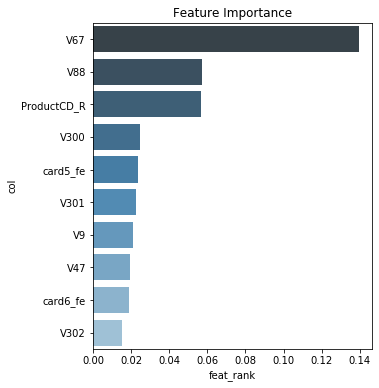

           col  feat_rank
0          V67   0.139434
1          V88   0.057244
2  ProductCD_R   0.056509
3         V300   0.024647
4     card5_fe   0.023890
5         V301   0.022385
6           V9   0.020888
7          V47   0.019428
8     card6_fe   0.018848
9         V302   0.015161


In [71]:
# TESTING XGBClassifier n_estimators=100
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)

Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)
threshold:  0.1
roc auc score: 0.8095789024880347
confusion matrix:
 [[36932 20013]
 [   62  2047]]
threshold:  0.15
roc auc score: 0.8444455879644959
confusion matrix:
 [[41848 15097]
 [   97  2012]]
threshold:  0.2
roc auc score: 0.865026534175436
confusion matrix:
 [[45218 11727]
 [  135  1974]]
threshold:  0.25
roc auc score: 0.8743948235844848
confusion matrix:
 [[47581  9364]
 [  183  1926]]
threshold:  0.3
roc auc score: 0.8821739684515864
confusion matrix:
 [[49412  7533]
 [  218  1891]]
th

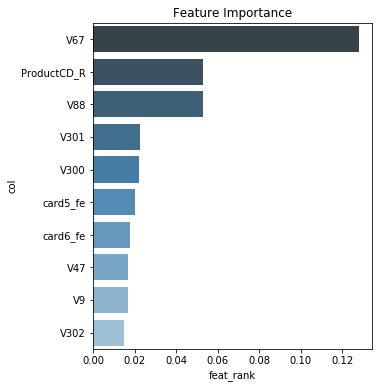

           col  feat_rank
0          V67   0.127891
1  ProductCD_R   0.053158
2          V88   0.053002
3         V301   0.022626
4         V300   0.021941
5     card5_fe   0.020173
6     card6_fe   0.018008
7          V47   0.016993
8           V9   0.016852
9         V302   0.014930


In [85]:
# testing XGBClassifier 200 n_estimators
model_current = XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
                              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
                              learning_rate=0.1, max_delta_step=0, max_depth=13,
                              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
                              nthread=None, objective='binary:logistic', random_state=42,
                              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
                              silent=None, subsample=0.5, verbosity=1)
mod.create_df_score_model(model_current)


Fitting model:
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=9,
                       min_impurity_decrease=0.1, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=3,
                       min_weight_fraction_leaf=0.3, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    6.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


roc auc score: 0.6633166330833978
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     56945
           1       0.08      0.57      0.14      2109

    accuracy                           0.75     59054
   macro avg       0.53      0.66      0.50     59054
weighted avg       0.95      0.75      0.83     59054


Printing df_scores...

     feat_tested     fn       fp  precision    recall  time_elapsed (min)  \
390         NaN  437.0  31562.0   0.050310  0.792793            0.917979   
391         NaN  437.0  31562.0   0.050310  0.792793            1.039733   
392         NaN  357.0   4560.0   0.277567  0.830725            4.303023   
393         NaN  367.0   2881.0   0.376812  0.825984           10.411890   
0           NaN  916.0  13612.0   0.080581  0.565671            0.131308   

         tn       tp  
390  1672.0  25383.0  
391  1672.0  25383.0  
392  1752.0  52385.0  
393  1742.0  54064.0  
0    1193.0  43333.0  


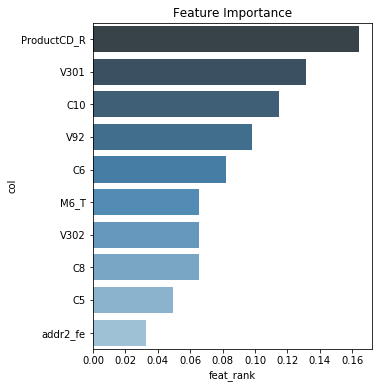

           col  feat_rank
0  ProductCD_R   0.163934
1         V301   0.131148
2          C10   0.114754
3          V92   0.098361
4           C6   0.081967
5         M6_T   0.065574
6         V302   0.065574
7           C8   0.065574
8           C5   0.049180
9     addr2_fe   0.032787


In [75]:
# testing RandomForestClassifier
model_current = RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=5, max_features='auto',
                                       max_leaf_nodes=9,
                                       min_impurity_decrease=0.1, min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=3,
                                       min_weight_fraction_leaf=0.3, n_estimators=100,
                                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                                       warm_start=False)
mod.create_df_score_model(model_current)


Fitting model:
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=11, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0, presort='auto',
                       random_state=42, splitter='best')
threshold:  0.1
roc auc score: 0.7896280386009625
confusion matrix:
 [[40465 16480]
 [  277  1832]]
threshold:  0.15
roc auc score: 0.8083025051290831
confusion matrix:
 [[47290  9655]
 [  451  1658]]
threshold:  0.2
roc auc score: 0.813868805471044
confusion matrix:
 [[49463  7482]
 [  508  1601]]
threshold:  0.25
roc auc score: 0.8144657562442961
confusion matrix:
 [[49909  7036]
 [  522  1587]]
threshold:  0.3
roc auc score: 0.8068523232531902
confusion matrix:
 [[51715  5230]
 [  621  1488]]
threshold:  0.35
roc auc score: 0.7953842271087443
confusion matrix:
 [[53

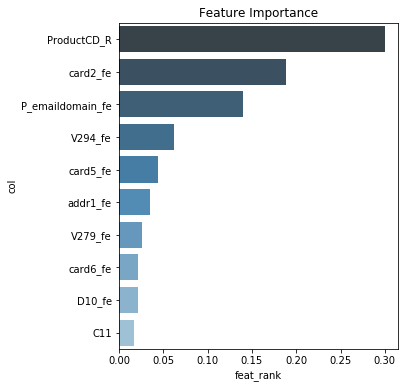

                col  feat_rank
0       ProductCD_R   0.299810
1          card2_fe   0.188458
2  P_emaildomain_fe   0.140255
3           V294_fe   0.061730
4          card5_fe   0.044080
5          addr1_fe   0.035400
6           V279_fe   0.025616
7          card6_fe   0.021235
8            D10_fe   0.021186
9               C11   0.017006


In [80]:
# testing DecisionTreeClassifier max_depth=11
model_current = DecisionTreeClassifier(class_weight='balanced',
                                       criterion='entropy', max_depth=11, max_features=None,
                                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       min_impurity_split=None, min_samples_leaf=9,
                                       min_samples_split=5, min_weight_fraction_leaf=0,
                                       presort='auto', random_state=42, splitter='best')

mod.create_df_score_model(model_current)

Fitting model:
 DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=13, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=5,
                       min_weight_fraction_leaf=0, presort='auto',
                       random_state=42, splitter='best')
threshold:  0.1
roc auc score: 0.8028863292635816
confusion matrix:
 [[42353 14592]
 [  291  1818]]
threshold:  0.15
roc auc score: 0.8175924620268423
confusion matrix:
 [[47403  9542]
 [  416  1693]]
threshold:  0.2
roc auc score: 0.8182677536379862
confusion matrix:
 [[50072  6873]
 [  512  1597]]
threshold:  0.25
roc auc score: 0.8171961282464953
confusion matrix:
 [[51300  5645]
 [  562  1547]]
threshold:  0.3
roc auc score: 0.8081604199871596
confusion matrix:
 [[52458  4487]
 [  643  1466]]
threshold:  0.35
roc auc score: 0.8035590063215983
confusion matrix:
 [[5

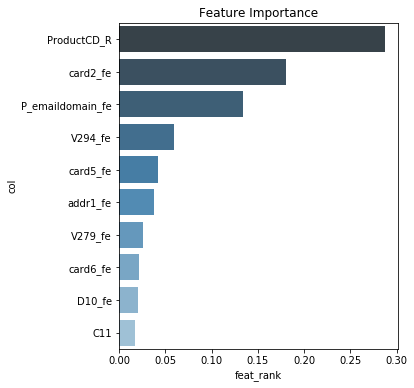

                col  feat_rank
0       ProductCD_R   0.287072
1          card2_fe   0.180950
2  P_emaildomain_fe   0.134429
3           V294_fe   0.059769
4          card5_fe   0.042207
5          addr1_fe   0.037437
6           V279_fe   0.025849
7          card6_fe   0.021462
8            D10_fe   0.020395
9               C11   0.017218


In [81]:
# testing DecisionTreeClassifier max_depth=13
model_current = DecisionTreeClassifier(class_weight='balanced',
                                       criterion='entropy', max_depth=13, max_features=None,
                                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                                       min_impurity_split=None, min_samples_leaf=9,
                                       min_samples_split=5, min_weight_fraction_leaf=0,
                                       presort='auto', random_state=42, splitter='best')

mod.create_df_score_model(model_current)

In [37]:
# bool_predict_proba = True
# model_current = LogisticRegression(random_state=42)
# mod.create_df_score_model(model_current)
# bool_predict_proba = False


In [41]:
# bool_predict_proba = False
# model_current = DecisionTreeClassifier(random_state=42, max_depth=4)
# mod.create_df_score_model(model_current)


In [8]:
# bool_predict_proba = False
# model_current = RandomForestClassifier(random_state=42, n_jobs=-1)
# mod.create_df_score_model(model_current)

In [40]:
# bool_predict_proba = False
# model_current = LogisticRegression(random_state=42)
# mod.create_df_score_model(model_current) 


In [82]:
class Model():
    def __init__(self):
        self.X_train = pd.DataFrame()
        self.y_train = pd.DataFrame()
        self.X_test = pd.DataFrame()
        self.y_test = pd.DataFrame()
        self.X_features = pd.DataFrame()
        self.y_target = pd.DataFrame()
        
    def create_df_score_model(self, model_current):
        '''scores model'''
        print("Fitting model:\n", model_current)
        y_pred, elapsed_time = self.add_model(model_current) 
        df_scores, df_temp, y_pred = self._score_model(y_pred, 
                                                       elapsed_time)
        self._save_results(df_scores, df_temp, y_pred)
        self._feature_importance(model_current)
        fe.col_fe = []
        
    def add_model(self, model):        
        '''fitting model and calculating time elapsed'''
        start_time = time.time()
        model.fit(mod.X_train, mod.y_train)
        y_pred = self._predict(model)
        elapsed_time = (time.time() - start_time) / 60
        return y_pred, elapsed_time
    
    def _predict(self, model):
        '''make prediction'''
        if bool_predict_proba:
            y_pred = self._predict_proba(model)
            return y_pred 
        else:
            y_pred = model.predict(mod.X_test)
            return y_pred
        
    def _predict_proba(self, model):
        try:
            y_pred_prob = model.predict_proba(mod.X_test)
            y_pred_class = self._predict_proba_threshold(y_pred_prob)
            return y_pred_class
        except:
            print("Model does not have predict_proba attribute.")
            
    def _predict_proba_threshold(self, y_pred_prob):
        for threshold in [.1, .15, .2, .25, .3, .35, .4, .45, .5]:
            print('threshold: ', threshold)
            y_pred_class = binarize(y_pred_prob, threshold)[:,1]
            print('roc auc score:', roc_auc_score(mod.y_test, y_pred_class))
            print('confusion matrix:\n', confusion_matrix(mod.y_test, y_pred_class))
        return y_pred_class
            
#     def _create_roc_curve(self, y_pred_class):
#         fpr, tpr, thresholds = roc_curve(mod.y_test, y_pred_class)
#         plt.plot(fpr, tpr)
#         plt.xlim([0.0, 1.0])
#         plt.ylim([0.0, 1.0])
#         plt.title("ROC curve for classifier")
#         plt.xlabel("False Positive Rate (1 - Specificity)")
#         plt.ylabel("True Positive Rate (Sensitivity)")
#         plt.grid(True)
#         plt.show()
        
    def _score_model(self, y_pred, elapsed_time):      
        '''creating dataframe with score results'''
        col_recall, col_precision, col_time = self._calc_scores(y_pred, 
                                                                  elapsed_time)        
        df_conf_matrix = self._confusion_matrix(y_pred)
        df_temp = pd.concat([col_recall, col_precision, df_conf_matrix, col_time], axis=1)
        if fe.col_fe:
            df_temp = self._concat_new_feat(df_temp)
        df_scores = self._read_create_score_file(df_temp)
        return df_scores, df_temp, y_pred

    def _calc_scores(self, y_pred, elapsed_time):
        '''calculating recall, precision and elapsed time'''
        col_recall = pd.Series(recall_score(mod.y_test, y_pred), name='recall')
        col_precision = pd.Series(precision_score(mod.y_test, y_pred), name='precision')
        col_time = pd.Series(elapsed_time, name='time_elapsed (min)')
        print("roc auc score:", roc_auc_score(mod.y_test, y_pred))
        return col_recall, col_precision, col_time
    
    def _confusion_matrix(self, y_pred):
        '''creating confusion matrix dataframe'''
        df_conf_matrix = pd.DataFrame(confusion_matrix(mod.y_test, y_pred))
        val_tp = pd.Series(df_conf_matrix[0][0], name='tp')
        val_fn = pd.Series(df_conf_matrix[0][1], name='fn')
        val_fp = pd.Series(df_conf_matrix[1][0], name='fp')
        val_tn = pd.Series(df_conf_matrix[1][1], name='tn')
        return pd.concat([val_fn, val_fp, val_tp, val_tn], axis=1)

    def _concat_new_feat(self, df_temp):
        '''concatenate scoring results'''        
        print("\nThe following new features have been created:", fe.col_fe, '\n')
        if len(fe.col_fe) > 1: 
            fe.col_fe = "model score"
        col_fe = pd.Series(fe.col_fe, name='feat_tested')
        return pd.concat([col_fe, df_temp], axis=1)
    
    def _read_create_score_file(self, df_temp):
        '''reading or creating df_scores file'''
        try: 
            df_scores = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
            df_scores = df_scores.drop('Unnamed: 0', axis=1)
        except:
            print("\nCreating df_scores.csv file.") 
            df_scores = df_temp
        return df_scores
            
    def _save_results(self, df_scores, df_temp, y_pred):
        '''printing scores for new features'''            
        df_scores = pd.concat([df_scores, df_temp], axis=0)
        df_scores.to_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
        classif_report = classification_report(mod.y_test, y_pred)
        self._print_summary(classif_report, df_scores)
        self._save_summary(classif_report)

    def _print_summary(self, classif_report, df_scores):
        '''print last 5 rows of previous score results'''
        print(classif_report)
        print('\ndf_scores:\n\n', df_scores.tail(5))
    
    def _save_summary(self, classif_report):
        '''save score result summary to text file'''
        file_summary = open('/Users/krahman/work/fraud_detection/saved_files/df_scores_summary.txt', "a")
        file_summary.write('New features created from: ' 
                           + fe.str_list_col_fe 
                           + '\n')
        file_summary.write(classif_report)
        file_summary.close()
        
    def _feature_importance(self, model):
        '''create feature importance dataframe and bar plot'''
        try:
            df_feat_rank = self._feat_import_create_df(model)
            self._feat_import_create_plot(df_feat_rank)
            print(df_feat_rank[0:10].reset_index(drop=True))
        except:
            print("\nmodel does not have _feature_importance attribute.")
        
    def _feat_import_create_df(self, model):
        '''creating dataframe of important features'''
        col_name = pd.Series(fe.df_feat.columns, name='col')
        col_feat_rank = pd.Series(model.feature_importances_, 
                                  name='feat_rank')
        df_feat_rank = pd.concat([col_name, col_feat_rank], axis=1)
        df_feat_rank = df_feat_rank.sort_values('feat_rank', ascending=False)
        return df_feat_rank
    
    def _feat_import_create_plot(self, df_feat_rank):
        '''create feature importance bar plot'''
        plt.figure(figsize=(5,6))
        sns.barplot(df_feat_rank.feat_rank[0:10],
                    df_feat_rank.col[0:10],
                    palette='Blues_d')
        plt.title('Feature Importance')
        plt.show()
        
mod = Model()

In [64]:
# model_xgbc = XGBClassifier()
# model_xgbc.fit(mod.X_train, mod.y_train)
# y_pred_xgbc = model_xgbc.predict(mod.X_test)
# print(classification_report(mod.y_test, y_pred_xgbc))
# print(confusion_matrix(mod.y_test, y_pred_xgbc))

In [ ]:
# model_cbc = CatBoostClassifier()
# X_test
# model_cbc.fit(mod.X_train, mod.y_train)
# # y_pred_cbc = model_cbc.predict(mod.y_test)
# # print(classification_report(mod.y_test, y_pred_cbc))
# # print(confusion_matrix(mod.y_test, y_pred_cbc))
# test_data = Pool(mod.X_test)
# y_pred_cbc = model_cbc.predict(test_data)
# print(classification_report(mod.y_test, y_pred_cbc))
# print(confusion_matrix(mod.y_test, y_pred_cbc))


In [66]:
# # base model
# model_lr_temp = LogisticRegression(random_state=42, n_jobs=-1)
# model_lr_temp.fit(mod.X_train, mod.y_train)
# pred_lr = model_lr_temp.predict(mod.X_test)
# print(confusion_matrix(mod.y_test, pred_lr))
# print(roc_auc_score(mod.y_test, pred_lr))
# # NEXT, we fixed our downsample and upsamp

In [65]:
# model_lr_temp.fit(mod.X_train, mod.y_train)
# pred_lr = model_lr_temp.predict(mod.X_test)
# print(confusion_matrix(mod.y_test, pred_lr))
# print(roc_auc_score(mod.y_test, pred_lr))

## Model Tuning

#### RFC Tuning

#### Manual Tuning - XGBClassifier

In [18]:
### Tuning XGBClassifier READY ###
print('tuning xgbc')
xgbc = XGBClassifier(n_jobs=-1, random_state=42)

max_depth = [2,3,5,7,9,11,13]
# learning_rate = [0,.1,.3,.5,.7,.9]
booster = ['gbtree', 'gblinear', 'dart']
subsample = [.1,.3,.5,.7]
colsample_bytree = [.1,.3,.5,.7]
colsample_bylevel = [0,.1,.3,.5,.7,.9,1]
colsample_bynode = [.1,.3,.5,.7]
reg_alpha = [0,1,3,5,7]
reg_lambda = [1,3,5,7]
scale_pos_weight = [1,3,5,7]
base_score = [.1,.2,.3,.4,.5]

hyperparameters = dict(max_depth=max_depth, 
#                        learning_rate=learning_rate, 
                       booster=booster, 
                       subsample=subsample, 
                       colsample_bytree=colsample_bytree, colsample_bylevel=colsample_bylevel, 
                       colsample_bynode=colsample_bynode, reg_alpha=reg_alpha, reg_lambda=reg_lambda, 
                       scale_pos_weight=scale_pos_weight,
                       base_score=base_score
                      )

clf = RandomizedSearchCV(xgbc, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best booster:', best_model.best_estimator_.get_params()['booster'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print('Best colsample_bytree:', best_model.best_estimator_.get_params()['colsample_bytree'])
print('Best colsample_bylevel:', best_model.best_estimator_.get_params()['colsample_bylevel'])
print('Best colsample_bynode:', best_model.best_estimator_.get_params()['colsample_bynode'])
print('Best reg_alpha:', best_model.best_estimator_.get_params()['reg_alpha'])
print('Best reg_lambda:', best_model.best_estimator_.get_params()['reg_lambda'])
print('Best scale_pos_weight:', best_model.best_estimator_.get_params()['scale_pos_weight'])
print('Best base_score:', best_model.best_estimator_.get_params()['base_score'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


tuning xgbc
Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 7.5min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.5min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.986, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 21.3min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.985, total= 6.9min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 28.2min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.0min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 34.2min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.988, total= 6.2min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 40.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.3min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 46.7min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.3min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 53.0min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.987, total= 6.4min
[CV] subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 59.4min remaining:    0.0s


[CV]  subsample=0.5, scale_pos_weight=3, reg_lambda=5, reg_alpha=5, max_depth=9, colsample_bytree=0.5, colsample_bynode=0.7, colsample_bylevel=0.9, booster=dart, base_score=0.3, score=0.988, total= 6.6min
[CV] subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4 
[CV]  subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4, score=0.966, total= 2.6min
[CV] subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4 
[CV]  subsample=0.7, scale_pos_weight=1, reg_lambda=7, reg_alpha=7, max_depth=11, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0, booster=dart, base_score=0.4, score=0.964, total= 2.6min
[CV] subsample=0.7, scale_pos_weigh

[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.796, total= 1.6min
[CV] subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5 
[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.804, total= 1.6min
[CV] subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5 
[CV]  subsample=0.5, scale_pos_weight=7, reg_lambda=1, reg_alpha=5, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.7, colsample_bylevel=1, booster=gblinear, base_score=0.5, score=0.802, total= 1.7min
[CV] subsample=0.5, s

[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.984, total= 2.4min
[CV] subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3 
[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.986, total=14.8min
[CV] subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3 
[CV]  subsample=0.7, scale_pos_weight=3, reg_lambda=1, reg_alpha=7, max_depth=9, colsample_bytree=0.7, colsample_bynode=0.1, colsample_bylevel=0.9, booster=gbtree, base_score=0.3, score=0.987, total= 2.6min
[CV] subsample=0.7, s

[CV]  subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1, score=0.987, total= 4.3min
[CV] subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1 
[CV]  subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1, score=0.986, total= 4.4min
[CV] subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1 
[CV]  subsample=0.1, scale_pos_weight=3, reg_lambda=3, reg_alpha=0, max_depth=13, colsample_bytree=0.5, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.1, score=0.987, total= 4.5min
[CV] subsample=0.1, scale_pos_weight

[CV]  subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3, score=0.984, total= 2.8min
[CV] subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3 
[CV]  subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3, score=0.983, total= 2.8min
[CV] subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3 
[CV]  subsample=0.3, scale_pos_weight=5, reg_lambda=7, reg_alpha=5, max_depth=7, colsample_bytree=0.3, colsample_bynode=0.3, colsample_bylevel=1, booster=dart, base_score=0.3, score=0.984, total= 2.8min


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 315.8min finished


Best max_depth: 13
Best learning_rate: 0.1
Best booster: gbtree
Best subsample: 0.5
Best colsample_bytree: 0.7
Best colsample_bylevel: 0.3
Best colsample_bynode: 0.5
Best reg_alpha: 3
Best reg_lambda: 5
Best scale_pos_weight: 5
Best base_score: 0.4


In [19]:
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)

XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_scale_pos_weight,param_reg_lambda,param_reg_alpha,param_max_depth,param_colsample_bytree,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,395.304133,25.412146,0.587299,0.052609,0.5,3,5,5,9,0.5,...,0.985380,0.986789,0.987938,0.986694,0.987347,0.986711,0.987547,0.986829,0.000743,2
1,167.217239,11.165350,0.489047,0.155241,0.7,1,7,7,11,0.7,...,0.963229,0.964751,0.967276,0.963401,0.966066,0.964305,0.966658,0.965024,0.001343,7
2,120.322799,8.478442,0.271042,0.108111,0.1,7,3,7,2,0.7,...,0.961926,0.962940,0.965645,0.961338,0.963113,0.962412,0.964037,0.963005,0.001308,8
3,99.684576,5.295310,0.226211,0.090092,0.5,7,1,5,9,0.7,...,0.802181,0.798554,0.805074,0.801674,0.804025,0.797907,0.806804,0.801659,0.003228,10
4,203.073417,25.312860,0.677408,0.173201,0.5,5,5,3,13,0.7,...,0.987628,0.988995,0.989606,0.988777,0.989180,0.988744,0.989257,0.988861,0.000556,1
5,217.663624,223.572931,0.553119,0.219257,0.7,3,1,7,9,0.7,...,0.984488,0.985504,0.986885,0.985129,0.985695,0.984936,0.986337,0.985598,0.000679,4
6,103.800450,5.746303,0.394553,0.301245,0.1,7,7,3,3,0.3,...,0.959114,0.960575,0.963978,0.959773,0.963111,0.959996,0.962418,0.961344,0.001475,9
7,305.320971,59.342621,0.606575,0.120821,0.1,3,3,0,13,0.5,...,0.985453,0.986445,0.987005,0.985547,0.986576,0.985673,0.987112,0.986233,0.000623,3
8,102.538558,3.363380,0.421863,0.036955,0.5,3,5,7,11,0.1,...,0.982312,0.983491,0.984753,0.982607,0.983767,0.982724,0.984011,0.983344,0.000777,5
9,173.911546,5.071884,0.338486,0.032476,0.3,5,7,5,7,0.3,...,0.982008,0.983266,0.984789,0.982414,0.983546,0.982560,0.983857,0.983167,0.000871,6


In [ ]:
###### testing manual tuning ######
### manual xbgc tuning
max_depth = [3,5,7,9,11,13,15]
# max_depth = [1,3,5]
list_time_elapsed = []
list_roc_auc_score = []
for val in max_depth:
    model_xgbc = XGBClassifier(max_depth=val, n_jobs=-1, random_state=42)
    
    start_time = time.time()
    model_xgbc.fit(mod.X_train_test, mod.y_train)
    y_pred_xgbc = model_xgbc.predict(mod.X_test)
    elapsed_time = (time.time() - start_time) / 60
    
    score_roc_auc = roc_auc_score(mod.y_test, y_pred_xgbc)
    print(score_roc_auc) #delete
    list_time_elapsed.append(elapsed_time)
    list_roc_auc_score.append(score_roc_auc)
    print('max depth: ', val)
    print(confusion_matrix(mod.y_test, y_pred_xgbc))

col_time_elapsed = pd.Series(list_time_elapsed)
col_roc_score = pd.Series(list_roc_auc_score)
col_max_depth = pd.Series(max_depth)
df_results_xgbc = pd.concat([col_max_depth, col_roc_score,col_time_elapsed], 
                            keys=['max_depth', 'roc_auc_score', 'time_elap'], 
                            axis=1)
print(df_results_xgbc)

sns.lineplot(x='max_depth', y='roc_auc_score', data=df_results_xgbc)
plt.title("XGBC manual tuning")
plt.show()

In [ ]:
#### Tuning RandomForestClassifier READY ####
rfc = RandomForestClassifier(oob_score=False, n_jobs=1, random_state=42, verbose=1)

n_estimators = [50,75,100,125,150,200]
criterion = ['gini', 'entropy']
max_depth = [3,5,7,9,11,13,15]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,2,4,6,8,10]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
max_leaf_nodes = [2,3,5,7,9,None]
min_impurity_decrease = [0,.1,.3,.5,.7,.9]

# n_estimators = [50,75,100,125]
# criterion = ['gini']
# max_depth = [2,3,4,5,6,7,None]
# min_samples_split = [6,7,8,9]
# min_samples_leaf = [1,2]
# min_weight_fraction_leaf = [0]
# max_features = ['auto', 'sqrt', 'log2', None]
# max_leaf_nodes = [None]
# min_impurity_decrease = [0]

hyperparameters = dict(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, 
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf, min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, max_leaf_nodes=max_leaf_nodes,
                       min_impurity_decrease=min_impurity_decrease
                      )

clf = RandomizedSearchCV(rfc, hyperparameters, random_state=42, cv=5, verbose=5, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best max_leaf_nodes:', best_model.best_estimator_.get_params()['max_leaf_nodes'])
print('Best min_impurity_decrease:', best_model.best_estimator_.get_params()['min_impurity_decrease'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [24]:
# ###### testing manual tuning ######
# ### manual lr tuning

# penalty = ['l1', 'l2', 'elasticnet','none']

# list_time_elapsed = []
# list_roc_auc_score = []
# for val in penalty:
#     model = LogisticRegression(penalty=val, n_jobs=1, random_state=42)
    
#     start_time = time.time()
#     model.fit(mod.X_train, mod.y_train)
#     y_pred = model.predict(mod.X_test)
#     elapsed_time = (time.time() - start_time) / 60
    
#     score_roc_auc = roc_auc_score(mod.y_test, y_pred)
#     print(score_roc_auc) #delete
#     list_time_elapsed.append(elapsed_time)
#     list_roc_auc_score.append(score_roc_auc)
#     print('penalty: ', val)
#     print(confusion_matrix(mod.y_test, y_pred))

# col_time_elapsed = pd.Series(list_time_elapsed)
# col_roc_score = pd.Series(list_roc_auc_score)
# col_penalty = pd.Series(penalty) ### UPDATE
# df_results = pd.concat([col_max_depth, col_roc_score,col_time_elapsed], 
#                             keys=['penalty', 'roc_auc_score', 'time_elap'], 
#                             axis=1)
# print(df_results)

# sns.lineplot(x='penalty', y='roc_auc_score', data=df_results_xgbc)
# plt.title("lr manual tuning")
# plt.show()

In [ ]:
#### LR Tuning ####
lr = LogisticRegression(random_state=42, n_jobs=-1)

penalty = ['l1', 'l2', 'elasticnet','none']
tol = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]
C = [1e-1,.2,.3,.5,.7,1]
fit_intercept = [True,False]
intercept_scaling = [1,.1,.01,.001]
class_weight = ['balanced', None]
solver = ['newton-cg', 'lbfgs', 'sag']#, 'liblinear','saga']
max_iter = [50,75,100,150,200]
multi_class = ['auto', 'ovr', 'multinomial']
l1_ratio = [1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7]


hyperparameters = dict(penalty=penalty, 
                       tol=tol, 
                       C=C, 
                       fit_intercept=fit_intercept,
                       intercept_scaling=intercept_scaling, 
                       class_weight=class_weight,
                       solver=solver, 
                       max_iter=max_iter
                       multi_class=multi_class, 
                       l1_ratio=l1_ratio
                      )

clf = RandomizedSearchCV(lr, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing

# best hyper parameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best tol:', best_model.best_estimator_.get_params()['tol'])
print('Best C:', best_model.best_estimator_.get_params()['C'])
print('Best fit_intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
print('Best intercept_scaling:', best_model.best_estimator_.get_params()['intercept_scaling'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print('Best solver:', best_model.best_estimator_.get_params()['solver'])
print('Best max_iter:', best_model.best_estimator_.get_params()['max_iter'])
print('Best multi_class:', best_model.best_estimator_.get_params()['multi_class'])
print('Best l1_ratio:', best_model.best_estimator_.get_params()['l1_ratio'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [250]:
# np.sum(mod.y_target[mod.y_target==0].isnull())
df_temp = pd.concat([mod.X_features, mod.y_target], keys=['features','target'],axis=1).sample(n=1000)


In [252]:
mod.X_features_test = df_temp.features
mod.y_target_test = df_temp.target


In [ ]:
#### Tuning DTC READY ####
dt = DecisionTreeClassifier(random_state=42, n_jobs=-1)

criterion = ['gini', 'entropy']
splitter = ['best', 'random']
max_depth = [3,5,7,9,11]
min_samples_split = [2,3,5,7,9]
min_samples_leaf = [1,3,5,7,9]
min_weight_fraction_leaf = [0,.1,.2,.3,.4,.5]
max_features = ['auto', 'sqrt', 'log2', None]
class_weight = ['balanced', None]

hyperparameters = dict(criterion=criterion, splitter=splitter, max_depth=max_depth, 
                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                       min_weight_fraction_leaf=min_weight_fraction_leaf,
                       max_features=max_features, class_weight=class_weight
                      )

clf = RandomizedSearchCV(dt, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)
# best_model = clf.fit(mod.X_features_test, mod.y_target_test) #testing
 
# best hyper parameters
print('Best criterion:', best_model.best_estimator_.get_params()['criterion'])
print('Best splitter:', best_model.best_estimator_.get_params()['splitter'])
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best min_samples_split:', best_model.best_estimator_.get_params()['min_samples_split'])
print('Best min_samples_leaf:', best_model.best_estimator_.get_params()['min_samples_leaf'])
print('Best min_weight_fraction_leaf:', best_model.best_estimator_.get_params()['min_weight_fraction_leaf'])
print('Best max_features:', best_model.best_estimator_.get_params()['max_features'])
print('Best class_weight:', best_model.best_estimator_.get_params()['class_weight'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)


In [58]:
# testing catboost
cbc = CatBoostClassifier(random_state=42)
cbc.fit(mod.X_features, mod.y_target)
y_pred_cbc = cbc.predict(mod.X_test)
print(roc_auc_score(mod.y_test, y_pred_cbc))
confusion_matrix(mod.y_test, y_pred_cbc)

Learning rate set to 0.096819
0:	learn: 0.5974147	total: 368ms	remaining: 6m 7s
1:	learn: 0.5392678	total: 630ms	remaining: 5m 14s
2:	learn: 0.4915173	total: 784ms	remaining: 4m 20s
3:	learn: 0.4398323	total: 929ms	remaining: 3m 51s
4:	learn: 0.4039320	total: 1.55s	remaining: 5m 8s
5:	learn: 0.3829470	total: 1.72s	remaining: 4m 44s
6:	learn: 0.3573045	total: 1.87s	remaining: 4m 25s
7:	learn: 0.3330280	total: 2.03s	remaining: 4m 12s
8:	learn: 0.3187945	total: 2.42s	remaining: 4m 27s
9:	learn: 0.3050905	total: 2.61s	remaining: 4m 18s
10:	learn: 0.2945899	total: 2.96s	remaining: 4m 25s
11:	learn: 0.2855216	total: 3.36s	remaining: 4m 36s
12:	learn: 0.2754627	total: 3.92s	remaining: 4m 57s
13:	learn: 0.2699601	total: 4.07s	remaining: 4m 46s
14:	learn: 0.2635532	total: 4.38s	remaining: 4m 47s
15:	learn: 0.2591132	total: 4.54s	remaining: 4m 39s
16:	learn: 0.2549411	total: 4.68s	remaining: 4m 30s
17:	learn: 0.2482291	total: 4.82s	remaining: 4m 22s
18:	learn: 0.2446053	total: 4.97s	remaining: 4

158:	learn: 0.1497307	total: 39.9s	remaining: 3m 30s
159:	learn: 0.1494894	total: 40.1s	remaining: 3m 30s
160:	learn: 0.1492489	total: 40.2s	remaining: 3m 29s
161:	learn: 0.1490791	total: 40.4s	remaining: 3m 28s
162:	learn: 0.1489446	total: 40.6s	remaining: 3m 28s
163:	learn: 0.1487970	total: 40.9s	remaining: 3m 28s
164:	learn: 0.1486638	total: 41s	remaining: 3m 27s
165:	learn: 0.1485293	total: 41.2s	remaining: 3m 26s
166:	learn: 0.1483947	total: 41.3s	remaining: 3m 25s
167:	learn: 0.1482535	total: 41.8s	remaining: 3m 26s
168:	learn: 0.1480183	total: 41.9s	remaining: 3m 26s
169:	learn: 0.1478997	total: 42s	remaining: 3m 25s
170:	learn: 0.1477164	total: 42.2s	remaining: 3m 24s
171:	learn: 0.1475409	total: 42.5s	remaining: 3m 24s
172:	learn: 0.1473429	total: 42.7s	remaining: 3m 24s
173:	learn: 0.1471793	total: 42.9s	remaining: 3m 23s
174:	learn: 0.1470081	total: 43s	remaining: 3m 22s
175:	learn: 0.1466012	total: 43.3s	remaining: 3m 22s
176:	learn: 0.1464606	total: 43.4s	remaining: 3m 21s

316:	learn: 0.1296291	total: 1m 7s	remaining: 2m 25s
317:	learn: 0.1295564	total: 1m 7s	remaining: 2m 25s
318:	learn: 0.1294825	total: 1m 7s	remaining: 2m 25s
319:	learn: 0.1293216	total: 1m 8s	remaining: 2m 25s
320:	learn: 0.1292673	total: 1m 8s	remaining: 2m 24s
321:	learn: 0.1291817	total: 1m 8s	remaining: 2m 24s
322:	learn: 0.1291105	total: 1m 8s	remaining: 2m 23s
323:	learn: 0.1290103	total: 1m 8s	remaining: 2m 23s
324:	learn: 0.1289503	total: 1m 8s	remaining: 2m 23s
325:	learn: 0.1288381	total: 1m 8s	remaining: 2m 22s
326:	learn: 0.1287669	total: 1m 9s	remaining: 2m 22s
327:	learn: 0.1285659	total: 1m 9s	remaining: 2m 22s
328:	learn: 0.1283703	total: 1m 9s	remaining: 2m 22s
329:	learn: 0.1282805	total: 1m 9s	remaining: 2m 21s
330:	learn: 0.1282083	total: 1m 9s	remaining: 2m 21s
331:	learn: 0.1281626	total: 1m 9s	remaining: 2m 20s
332:	learn: 0.1280684	total: 1m 10s	remaining: 2m 21s
333:	learn: 0.1279591	total: 1m 10s	remaining: 2m 20s
334:	learn: 0.1278946	total: 1m 10s	remainin

469:	learn: 0.1186453	total: 1m 55s	remaining: 2m 9s
470:	learn: 0.1186069	total: 1m 55s	remaining: 2m 9s
471:	learn: 0.1185489	total: 1m 55s	remaining: 2m 9s
472:	learn: 0.1185260	total: 1m 55s	remaining: 2m 8s
473:	learn: 0.1184700	total: 1m 55s	remaining: 2m 8s
474:	learn: 0.1184296	total: 1m 55s	remaining: 2m 7s
475:	learn: 0.1183791	total: 1m 55s	remaining: 2m 7s
476:	learn: 0.1183333	total: 1m 56s	remaining: 2m 7s
477:	learn: 0.1182541	total: 1m 56s	remaining: 2m 7s
478:	learn: 0.1181681	total: 1m 56s	remaining: 2m 6s
479:	learn: 0.1181265	total: 1m 56s	remaining: 2m 6s
480:	learn: 0.1180292	total: 1m 56s	remaining: 2m 5s
481:	learn: 0.1179869	total: 1m 56s	remaining: 2m 5s
482:	learn: 0.1179262	total: 1m 57s	remaining: 2m 5s
483:	learn: 0.1179018	total: 1m 57s	remaining: 2m 5s
484:	learn: 0.1178371	total: 1m 57s	remaining: 2m 4s
485:	learn: 0.1178089	total: 1m 57s	remaining: 2m 4s
486:	learn: 0.1177494	total: 1m 57s	remaining: 2m 4s
487:	learn: 0.1176763	total: 1m 57s	remaining:

624:	learn: 0.1102527	total: 2m 21s	remaining: 1m 25s
625:	learn: 0.1102218	total: 2m 21s	remaining: 1m 24s
626:	learn: 0.1101589	total: 2m 22s	remaining: 1m 24s
627:	learn: 0.1101333	total: 2m 22s	remaining: 1m 24s
628:	learn: 0.1100830	total: 2m 22s	remaining: 1m 24s
629:	learn: 0.1100684	total: 2m 22s	remaining: 1m 23s
630:	learn: 0.1100267	total: 2m 22s	remaining: 1m 23s
631:	learn: 0.1099767	total: 2m 22s	remaining: 1m 23s
632:	learn: 0.1099126	total: 2m 23s	remaining: 1m 23s
633:	learn: 0.1098443	total: 2m 23s	remaining: 1m 22s
634:	learn: 0.1097959	total: 2m 23s	remaining: 1m 22s
635:	learn: 0.1097383	total: 2m 23s	remaining: 1m 22s
636:	learn: 0.1096925	total: 2m 23s	remaining: 1m 21s
637:	learn: 0.1096546	total: 2m 23s	remaining: 1m 21s
638:	learn: 0.1095893	total: 2m 24s	remaining: 1m 21s
639:	learn: 0.1095394	total: 2m 24s	remaining: 1m 21s
640:	learn: 0.1095010	total: 2m 24s	remaining: 1m 21s
641:	learn: 0.1094757	total: 2m 24s	remaining: 1m 20s
642:	learn: 0.1094393	total:

779:	learn: 0.1033875	total: 2m 47s	remaining: 47.1s
780:	learn: 0.1033697	total: 2m 47s	remaining: 46.9s
781:	learn: 0.1033510	total: 2m 47s	remaining: 46.7s
782:	learn: 0.1033069	total: 2m 47s	remaining: 46.4s
783:	learn: 0.1032576	total: 2m 47s	remaining: 46.2s
784:	learn: 0.1032351	total: 2m 47s	remaining: 45.9s
785:	learn: 0.1032120	total: 2m 47s	remaining: 45.7s
786:	learn: 0.1031708	total: 2m 48s	remaining: 45.5s
787:	learn: 0.1031340	total: 2m 48s	remaining: 45.3s
788:	learn: 0.1030806	total: 2m 48s	remaining: 45s
789:	learn: 0.1030572	total: 2m 48s	remaining: 44.8s
790:	learn: 0.1030264	total: 2m 48s	remaining: 44.6s
791:	learn: 0.1030063	total: 2m 48s	remaining: 44.3s
792:	learn: 0.1029811	total: 2m 48s	remaining: 44.1s
793:	learn: 0.1029742	total: 2m 49s	remaining: 43.9s
794:	learn: 0.1029452	total: 2m 49s	remaining: 43.6s
795:	learn: 0.1029172	total: 2m 49s	remaining: 43.4s
796:	learn: 0.1028968	total: 2m 49s	remaining: 43.2s
797:	learn: 0.1028909	total: 2m 49s	remaining: 4

938:	learn: 0.0981958	total: 3m 9s	remaining: 12.3s
939:	learn: 0.0981675	total: 3m 9s	remaining: 12.1s
940:	learn: 0.0981340	total: 3m 9s	remaining: 11.9s
941:	learn: 0.0981023	total: 3m 10s	remaining: 11.7s
942:	learn: 0.0980809	total: 3m 10s	remaining: 11.5s
943:	learn: 0.0980353	total: 3m 10s	remaining: 11.3s
944:	learn: 0.0980154	total: 3m 10s	remaining: 11.1s
945:	learn: 0.0979744	total: 3m 10s	remaining: 10.9s
946:	learn: 0.0979542	total: 3m 10s	remaining: 10.7s
947:	learn: 0.0979129	total: 3m 10s	remaining: 10.5s
948:	learn: 0.0978612	total: 3m 10s	remaining: 10.3s
949:	learn: 0.0978359	total: 3m 11s	remaining: 10.1s
950:	learn: 0.0977834	total: 3m 11s	remaining: 9.85s
951:	learn: 0.0977774	total: 3m 11s	remaining: 9.65s
952:	learn: 0.0977687	total: 3m 11s	remaining: 9.44s
953:	learn: 0.0977440	total: 3m 11s	remaining: 9.24s
954:	learn: 0.0976980	total: 3m 11s	remaining: 9.04s
955:	learn: 0.0976657	total: 3m 12s	remaining: 8.84s
956:	learn: 0.0976171	total: 3m 12s	remaining: 8.

array([[55989,   956],
       [  500,  1609]])

In [28]:
### Tuning CatBoost READY ###
# Tune learning rate manually.
cbc = CatBoostClassifier(random_state=42)

max_depth = [2,3,5,7,9,11,13]
learning_rate = [.1,.3,.5,.7,.9]
# bagging_temperature = []
subsample = [1,3,5,7]
n_estimators = [50,75,100,150]
depth = [2,4,6,8,10]
grow_policy = ['SymmetricTree', 'Depthwise', 'Lossguide']


hyperparameters = dict(max_depth=max_depth, 
#                        learning_rate=learning_rate, 
                       n_estimators=n_estimators,
                       subsample=subsample,
#                        depth=depth,
                       grow_policy=grow_policy
                      )

clf = RandomizedSearchCV(cbc, hyperparameters, random_state=42, cv=10, verbose=10, n_jobs=1, scoring='roc_auc')
best_model = clf.fit(mod.X_features, mod.y_target)

# best hyper parameters
print('Best max_depth:', best_model.best_estimator_.get_params()['max_depth'])
print('Best learning_rate:', best_model.best_estimator_.get_params()['learning_rate'])
print('Best n_estimators:', best_model.best_estimator_.get_params()['n_estimators'])
print('Best subsample:', best_model.best_estimator_.get_params()['subsample'])
print(clf.best_estimator_)
pd.DataFrame(clf.cv_results_)



Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=1, n_estimators=100, max_depth=9, grow_policy=SymmetricTree 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Learning rate set to 0.5
0:	learn: 0.3517638	total: 974ms	remaining: 1m 36s
1:	learn: 0.2640057	total: 1.8s	remaining: 1m 28s
2:	learn: 0.2282460	total: 2.77s	remaining: 1m 29s
3:	learn: 0.2103504	total: 3.37s	remaining: 1m 20s
4:	learn: 0.2006201	total: 3.79s	remaining: 1m 12s
5:	learn: 0.1937147	total: 4.52s	remaining: 1m 10s
6:	learn: 0.1865759	total: 5.23s	remaining: 1m 9s
7:	learn: 0.1819507	total: 5.84s	remaining: 1m 7s
8:	learn: 0.1774145	total: 6.3s	remaining: 1m 3s
9:	learn: 0.1734796	total: 6.89s	remaining: 1m 2s
10:	learn: 0.1677005	total: 7.44s	remaining: 1m
11:	learn: 0.1646502	total: 7.95s	remaining: 58.3s
12:	learn: 0.1618970	total: 8.41s	remaining: 56.3s
13:	learn: 0.1597990	total: 9.29s	remaining: 57s
14:	learn: 0.1577593	total: 9.8s	remaining: 55.5s
15:	learn: 0.1560187	total: 10.2s	remaining: 53.7s
16:	learn: 0.1532521	total: 11.2s	remaining: 54.9s
17:	learn: 0.1512195	total: 11.9s	remaining: 54.1s
18:	learn: 0.1498575	total: 12.4s	remaining: 52.8s
19:	learn: 0.14819

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.8min remaining:    0.0s


[CV] subsample=1, n_estimators=100, max_depth=9, grow_policy=SymmetricTree 
Learning rate set to 0.5
0:	learn: 0.3678666	total: 1.06s	remaining: 1m 45s
1:	learn: 0.2734234	total: 2.43s	remaining: 1m 59s
2:	learn: 0.2340610	total: 3.3s	remaining: 1m 46s
3:	learn: 0.2113590	total: 3.65s	remaining: 1m 27s
4:	learn: 0.2023309	total: 4.4s	remaining: 1m 23s
5:	learn: 0.1927832	total: 4.77s	remaining: 1m 14s
6:	learn: 0.1863297	total: 8.16s	remaining: 1m 48s
7:	learn: 0.1798634	total: 9.22s	remaining: 1m 46s
8:	learn: 0.1758478	total: 9.65s	remaining: 1m 37s
9:	learn: 0.1692001	total: 10.4s	remaining: 1m 33s
10:	learn: 0.1656409	total: 10.8s	remaining: 1m 27s
11:	learn: 0.1626856	total: 11.1s	remaining: 1m 21s
12:	learn: 0.1592466	total: 11.8s	remaining: 1m 19s
13:	learn: 0.1576300	total: 12.2s	remaining: 1m 14s
14:	learn: 0.1554937	total: 12.7s	remaining: 1m 11s
15:	learn: 0.1532581	total: 13.1s	remaining: 1m 8s
16:	learn: 0.1516407	total: 13.5s	remaining: 1m 6s
17:	learn: 0.1493231	total: 1

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.8min remaining:    0.0s


Learning rate set to 0.5
0:	learn: 0.3573777	total: 615ms	remaining: 1m
1:	learn: 0.2708593	total: 947ms	remaining: 46.4s
2:	learn: 0.2303787	total: 1.5s	remaining: 48.4s
3:	learn: 0.2104509	total: 1.85s	remaining: 44.3s
4:	learn: 0.1993448	total: 2.45s	remaining: 46.5s
5:	learn: 0.1925785	total: 2.86s	remaining: 44.8s
6:	learn: 0.1829506	total: 3.57s	remaining: 47.5s
7:	learn: 0.1783673	total: 3.99s	remaining: 45.9s
8:	learn: 0.1744869	total: 4.63s	remaining: 46.9s
9:	learn: 0.1705928	total: 5.04s	remaining: 45.4s
10:	learn: 0.1664252	total: 5.79s	remaining: 46.9s
11:	learn: 0.1639460	total: 6.08s	remaining: 44.6s
12:	learn: 0.1616665	total: 6.72s	remaining: 45s
13:	learn: 0.1594031	total: 7.12s	remaining: 43.7s
14:	learn: 0.1569990	total: 7.62s	remaining: 43.2s
15:	learn: 0.1555530	total: 8.01s	remaining: 42s
16:	learn: 0.1544626	total: 8.78s	remaining: 42.9s
17:	learn: 0.1519710	total: 9.23s	remaining: 42s
18:	learn: 0.1497922	total: 9.67s	remaining: 41.2s
19:	learn: 0.1479423	total

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.8min remaining:    0.0s


Learning rate set to 0.5
0:	learn: 0.3505344	total: 749ms	remaining: 1m 14s
1:	learn: 0.2704401	total: 1.28s	remaining: 1m 2s
2:	learn: 0.2281601	total: 1.68s	remaining: 54.4s
3:	learn: 0.2123861	total: 2.05s	remaining: 49.2s
4:	learn: 0.2025944	total: 2.42s	remaining: 46s
5:	learn: 0.1960754	total: 3.11s	remaining: 48.7s
6:	learn: 0.1856251	total: 3.86s	remaining: 51.3s
7:	learn: 0.1804190	total: 4.31s	remaining: 49.6s
8:	learn: 0.1754210	total: 4.81s	remaining: 48.6s
9:	learn: 0.1723487	total: 5.84s	remaining: 52.6s
10:	learn: 0.1691242	total: 6.45s	remaining: 52.2s
11:	learn: 0.1658809	total: 6.87s	remaining: 50.4s
12:	learn: 0.1617025	total: 7.4s	remaining: 49.5s
13:	learn: 0.1576541	total: 7.88s	remaining: 48.4s
14:	learn: 0.1556424	total: 8.26s	remaining: 46.8s
15:	learn: 0.1542335	total: 8.76s	remaining: 46s
16:	learn: 0.1521521	total: 9.31s	remaining: 45.5s
17:	learn: 0.1505297	total: 9.94s	remaining: 45.3s
18:	learn: 0.1494514	total: 10.3s	remaining: 43.9s
19:	learn: 0.1465273

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.7min remaining:    0.0s


Learning rate set to 0.5
0:	learn: 0.3551216	total: 739ms	remaining: 1m 13s
1:	learn: 0.2753895	total: 1.33s	remaining: 1m 5s
2:	learn: 0.2280371	total: 2.1s	remaining: 1m 8s
3:	learn: 0.2135853	total: 2.77s	remaining: 1m 6s
4:	learn: 0.2000451	total: 3.37s	remaining: 1m 3s
5:	learn: 0.1923724	total: 4.15s	remaining: 1m 5s
6:	learn: 0.1847403	total: 4.53s	remaining: 1m
7:	learn: 0.1794842	total: 4.95s	remaining: 56.9s
8:	learn: 0.1751991	total: 5.45s	remaining: 55.1s
9:	learn: 0.1720694	total: 5.75s	remaining: 51.7s
10:	learn: 0.1689517	total: 6.3s	remaining: 51s
11:	learn: 0.1659353	total: 6.84s	remaining: 50.1s
12:	learn: 0.1627789	total: 7.39s	remaining: 49.5s
13:	learn: 0.1601283	total: 7.79s	remaining: 47.9s
14:	learn: 0.1583137	total: 8.19s	remaining: 46.4s
15:	learn: 0.1555892	total: 8.63s	remaining: 45.3s
16:	learn: 0.1515482	total: 9.07s	remaining: 44.3s
17:	learn: 0.1491752	total: 9.48s	remaining: 43.2s
18:	learn: 0.1483287	total: 9.91s	remaining: 42.2s
19:	learn: 0.1471773	t

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.5min remaining:    0.0s


Learning rate set to 0.5
0:	learn: 0.3621251	total: 925ms	remaining: 1m 31s
1:	learn: 0.2830097	total: 1.36s	remaining: 1m 6s
2:	learn: 0.2290945	total: 1.94s	remaining: 1m 2s
3:	learn: 0.2090335	total: 2.4s	remaining: 57.5s
4:	learn: 0.1991118	total: 2.92s	remaining: 55.6s
5:	learn: 0.1921329	total: 3.51s	remaining: 55s
6:	learn: 0.1868779	total: 3.93s	remaining: 52.2s
7:	learn: 0.1811223	total: 4.38s	remaining: 50.4s
8:	learn: 0.1751952	total: 4.82s	remaining: 48.7s
9:	learn: 0.1719664	total: 5.3s	remaining: 47.8s
10:	learn: 0.1686002	total: 6.2s	remaining: 50.2s
11:	learn: 0.1657147	total: 7.29s	remaining: 53.5s
12:	learn: 0.1618047	total: 8.56s	remaining: 57.3s
13:	learn: 0.1601897	total: 9.43s	remaining: 57.9s
14:	learn: 0.1572360	total: 10.2s	remaining: 57.8s
15:	learn: 0.1544518	total: 10.6s	remaining: 55.9s
16:	learn: 0.1527989	total: 11.3s	remaining: 55.1s
17:	learn: 0.1500211	total: 12.1s	remaining: 55.3s
18:	learn: 0.1480632	total: 12.5s	remaining: 53.3s
19:	learn: 0.1459592

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  6.3min remaining:    0.0s


Learning rate set to 0.5
0:	learn: 0.3529298	total: 539ms	remaining: 53.4s
1:	learn: 0.2780151	total: 880ms	remaining: 43.1s
2:	learn: 0.2375566	total: 1.26s	remaining: 40.7s
3:	learn: 0.2195839	total: 1.61s	remaining: 38.8s
4:	learn: 0.2079817	total: 2.03s	remaining: 38.7s
5:	learn: 0.1937233	total: 2.39s	remaining: 37.4s
6:	learn: 0.1871217	total: 2.73s	remaining: 36.2s
7:	learn: 0.1806085	total: 3.07s	remaining: 35.4s
8:	learn: 0.1765390	total: 3.37s	remaining: 34.1s
9:	learn: 0.1732171	total: 3.97s	remaining: 35.7s
10:	learn: 0.1706462	total: 4.36s	remaining: 35.3s
11:	learn: 0.1684389	total: 4.72s	remaining: 34.6s
12:	learn: 0.1655716	total: 5.04s	remaining: 33.7s
13:	learn: 0.1622482	total: 5.33s	remaining: 32.7s
14:	learn: 0.1597387	total: 5.67s	remaining: 32.2s
15:	learn: 0.1570448	total: 6s	remaining: 31.5s
16:	learn: 0.1543857	total: 6.3s	remaining: 30.7s
17:	learn: 0.1530646	total: 6.62s	remaining: 30.2s
18:	learn: 0.1513738	total: 6.94s	remaining: 29.6s
19:	learn: 0.1498336

[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.9min remaining:    0.0s


Learning rate set to 0.5
0:	learn: 0.3457547	total: 509ms	remaining: 50.3s
1:	learn: 0.2693729	total: 822ms	remaining: 40.3s
2:	learn: 0.2342542	total: 1.29s	remaining: 41.7s
3:	learn: 0.2182791	total: 1.68s	remaining: 40.4s
4:	learn: 0.2050912	total: 2.09s	remaining: 39.7s
5:	learn: 0.1942998	total: 2.56s	remaining: 40.1s
6:	learn: 0.1877297	total: 2.91s	remaining: 38.6s
7:	learn: 0.1828917	total: 3.24s	remaining: 37.2s
8:	learn: 0.1764570	total: 3.72s	remaining: 37.6s
9:	learn: 0.1721857	total: 4.11s	remaining: 37s
10:	learn: 0.1655971	total: 4.5s	remaining: 36.4s
11:	learn: 0.1619036	total: 4.81s	remaining: 35.3s
12:	learn: 0.1601400	total: 5.11s	remaining: 34.2s
13:	learn: 0.1581722	total: 5.4s	remaining: 33.2s
14:	learn: 0.1565986	total: 5.76s	remaining: 32.7s
15:	learn: 0.1542977	total: 6.15s	remaining: 32.3s
16:	learn: 0.1527964	total: 6.55s	remaining: 32s
17:	learn: 0.1502785	total: 6.8s	remaining: 31s
18:	learn: 0.1481050	total: 7.13s	remaining: 30.4s
19:	learn: 0.1464941	tota

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.7min remaining:    0.0s


Learning rate set to 0.5
0:	learn: 0.3540666	total: 518ms	remaining: 51.3s
1:	learn: 0.2688633	total: 960ms	remaining: 47s
2:	learn: 0.2368169	total: 1.35s	remaining: 43.6s
3:	learn: 0.2191351	total: 1.65s	remaining: 39.7s
4:	learn: 0.2093813	total: 2.03s	remaining: 38.6s
5:	learn: 0.2010497	total: 2.41s	remaining: 37.7s
6:	learn: 0.1931983	total: 2.79s	remaining: 37.1s
7:	learn: 0.1877752	total: 3.12s	remaining: 35.9s
8:	learn: 0.1836112	total: 3.46s	remaining: 35s
9:	learn: 0.1756548	total: 3.87s	remaining: 34.9s
10:	learn: 0.1707218	total: 4.2s	remaining: 34s
11:	learn: 0.1671451	total: 4.81s	remaining: 35.3s
12:	learn: 0.1608846	total: 5.21s	remaining: 34.9s
13:	learn: 0.1587348	total: 5.55s	remaining: 34.1s
14:	learn: 0.1568652	total: 5.91s	remaining: 33.5s
15:	learn: 0.1553256	total: 6.42s	remaining: 33.7s
16:	learn: 0.1529397	total: 6.73s	remaining: 32.9s
17:	learn: 0.1502055	total: 7.08s	remaining: 32.3s
18:	learn: 0.1489004	total: 7.43s	remaining: 31.7s
19:	learn: 0.1473301	to

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.3min remaining:    0.0s


Learning rate set to 0.5
0:	learn: 0.3445064	total: 506ms	remaining: 50.1s
1:	learn: 0.2722273	total: 891ms	remaining: 43.7s
2:	learn: 0.2282333	total: 1.28s	remaining: 41.5s
3:	learn: 0.2118496	total: 1.76s	remaining: 42.3s
4:	learn: 0.2004711	total: 2.27s	remaining: 43.2s
5:	learn: 0.1937070	total: 2.6s	remaining: 40.7s
6:	learn: 0.1813295	total: 2.97s	remaining: 39.5s
7:	learn: 0.1762894	total: 3.31s	remaining: 38.1s
8:	learn: 0.1724754	total: 3.65s	remaining: 36.9s
9:	learn: 0.1687139	total: 3.96s	remaining: 35.7s
10:	learn: 0.1657851	total: 4.3s	remaining: 34.8s
11:	learn: 0.1633152	total: 4.64s	remaining: 34s
12:	learn: 0.1597993	total: 4.96s	remaining: 33.2s
13:	learn: 0.1571714	total: 5.51s	remaining: 33.8s
14:	learn: 0.1555592	total: 5.82s	remaining: 33s
15:	learn: 0.1527024	total: 6.17s	remaining: 32.4s
16:	learn: 0.1513730	total: 6.49s	remaining: 31.7s
17:	learn: 0.1502105	total: 7.01s	remaining: 32s
18:	learn: 0.1484275	total: 7.38s	remaining: 31.5s
19:	learn: 0.1468319	tot

CatBoostError: catboost/private/libs/options/bootstrap_options.cpp:5: Taken fraction should in in (0,1]

In [21]:
# cbc.fit(x)
mod.X_train, mod.X_test, mod.y_train, mod.y_test = train_test_split(mod.X_features, 
                                                                    mod.y_target, 
                                                                    test_size=0.1, 
                                                                    random_state=42)

In [108]:
# cbc.fit(mod.X_train, mod.y_train)


In [ ]:
pred_cbc = cbc.predict(mod.X_test)
confusion_matrix(y_test, pred_cbc)


Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)
       isFraud
0            0
1            0
2            0
3            0
4            0
...        ...
59049        0
59050        0
59051        0
59052        0
59053        0

[59054 rows x 1 columns]
[0 0 0 ... 0 0 0]
roc auc score: 0.8850176446948032
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     56945
           1       0.34      0.83      0.48      2109

    accuracy                           0.94     59054
   macro avg       0.67    

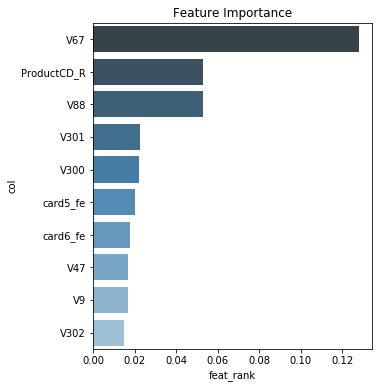

           col  feat_rank
0          V67   0.127891
1  ProductCD_R   0.053158
2          V88   0.053002
3         V301   0.022626
4         V300   0.021941
5     card5_fe   0.020173
6     card6_fe   0.018008
7          V47   0.016993
8           V9   0.016852
9         V302   0.014930
Fitting model:
 XGBClassifier(base_score=0.4, booster='gbtree', colsample_bylevel=0.3,
              colsample_bynode=0.5, colsample_bytree=0.7, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=13,
              min_child_weight=1, missing=None, n_estimators=200, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=3, reg_lambda=5, scale_pos_weight=5, seed=None,
              silent=None, subsample=0.5, verbosity=1)
       isFraud
0            0
1            0
2            0
3            0
4            0
...        ...
59049        0
59050        0
59051        0
59052        0
59053        0

[59054 rows x 1 columns]
[0 0 0 ... 

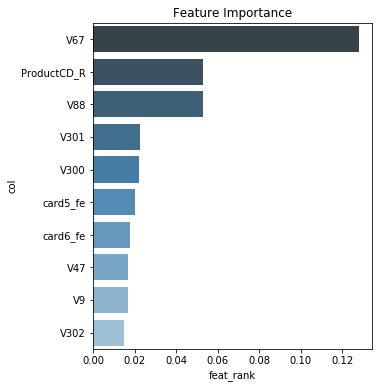

           col  feat_rank
0          V67   0.127891
1  ProductCD_R   0.053158
2          V88   0.053002
3         V301   0.022626
4         V300   0.021941
5     card5_fe   0.020173
6     card6_fe   0.018008
7          V47   0.016993
8           V9   0.016852
9         V302   0.014930


In [62]:
bool_predict_proba = False
# tuned model
current_model = RandomForestClassifier(
                                       max_depth=3, max_features='log2',
                                       min_impurity_decrease=0.0, 
                                       min_samples_leaf=1, min_samples_split=7,
                                       min_weight_fraction_leaf=0.0, n_estimators=50,
                                       n_jobs=-1, oob_score=False, random_state=42,
                                       verbose=0, warm_start=False)
mod.create_df_score_model(model_current)

# base model
current_model = RandomForestClassifier(random_state=42, n_jobs=-1)
mod.create_df_score_model(model_current)

In [ ]:
df_temp_read = pd.read_csv('/Users/krahman/work/fraud_detection/saved_files/df_scores.csv')
df_temp_read[len(df_temp_read)-40:]

In [ ]:
# # it reads the csv, creates a dataframe, then appends the results, then saves over the old version and keeps
# # a record of all columns in the tested dataframe.

# X = df_features.drop(col_target, axis=1)
# X = X.drop(col_id, axis=1)
# y = df_features[col_target]

# # we want to test a feature for feature engineering... we must 

# for col_original, col_new in zip(list_col, fe.list_new_feat):
#     print(col_original, col_new)
#     X[col_new] = fe.df_feat[col_new]
#     X = X.drop(col_original, axis=1)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
#     start_time = time.time()

#     sm = SMOTE(random_state=42, ratio=1.0, n_jobs=-1) # SMOTE
#     X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    
#     model_lr_pca_sm = LogisticRegression(random_state=42, n_jobs=-1) # logistic regression
#     model_lr_pca_sm.fit(X_train_res, y_train_res)
    
#     y_pred = model_lr_pca_sm.predict(X_test)     # predict
    
#     elapsed_time = time.time() - start_time
#     print('\nTime elapsed:', elapsed_time / 60)
#     print(confusion_matrix(y_test, y_pred))
#     print(classification_report(y_test, y_pred))
    
# #     X = X.drop(col, axis=1)
#     print(list(X.columns))

In [ ]:
# fe.df_feat['time_delta'] = df_temp['time_delta']
# fe.df_feat['time_delta_week'] = df_temp['time_delta']/7
# fe.df_feat['time_delta_month'] = df_temp['time_delta']/30
# fe.df_feat

In [ ]:
##### implement into feature engineering class. days lapsed
df_temp = fe.df_feat[['TransactionDT']]
df_temp['time_delta'] = 0
len_df_temp = df_temp.shape[0]
for i in range(1,len(df_temp['TransactionDT'][0:len_df_temp])):
    val_time_1 = df_temp.loc[i - 1, 'TransactionDT']
    val_time_2 = df_temp.loc[i, 'TransactionDT']
    val_time_delta = val_time_2 - val_time_1
    df_temp.loc[i, 'time_delta'] = val_time_delta
    
    

In [ ]:
# KEEP
# class Results():
#     def __init__(self):
#         self.model_lr_results = pd.DataFrame()
#         self.model_recall = []
#         self.model_precision = []
# #         self.model_auc_score = []
        
#     def _score(self, y_true, y_pred):
#         self.model_recall.append(recall_score(y_true, y_pred))
#         self.model_precision.append(precision_score(y_true, y_pred))
#         self._create_series()
# #         self.model_auc_score.append(roc_auc_score(y_true, y_pred[:,1]))

#     def _create_series(self):
#         model_recall = pd.Series(self.model_recall, name='recall')
#         model_precision = pd.Series(self.model_precision, name='precision')
# #         model_auc_score = pd.Series(self.model_auc_score, name='auc_score')
#         model_results_final = pd.concat([model_recall, model_precision],axis=1)
#         return model_results_final

In [ ]:
# notes, do we need to visualize our results?? We need to look at our confusion matrix
# and decide how to improve our results from here... Test and see what happens if we 
# increase our principal components... test removing columns, adding columns, imputing
# certain columns all together. 

# test imputing 500 or less for ohe. Then test dropping card1 due to its number
# of unique values that would make our data very high dimensional. We can try only ohe for
# the entire dataset to see how our model performs over all... Though.. it will likely run 
# out of memory and crash. 

# ALSO test probabilities on logisticregression


In [ ]:
# %matplotlib inline
# plt.rcParams['font.size'] = 14

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
# plt.hist(y_pred_prob[:,1], bins=8)
# plt.xlim(0,1)
# plt.title("Histogram of Probability of Fraud")
# plt.xlabel("Predicted probability of Fraud")
# plt.ylabel("Frequency")

# y_pred_prob = model_lr_pca.predict_proba(X_pca)
e

# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

# fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
# plt.plot(fpr, tpr)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.0])
# plt.title("ROC curve for fraud detection classifier")
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity)")
# plt.grid(True)
# plt.show()

In [ ]:
# def evaluate_threshold(threshold):
#     print("Sensitivity:", tpr[thresholds > threshold][-1])
#     print("Specificity:", 1 - fpr[thresholds > threshold][-1],'\n')
    
# evaluate_threshold(.5)
# evaluate_threshold(.2)
# evaluate_threshold(.1)

# print(roc_auc_score(y, y_pred_prob[:,1]))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_test2) # actual prediction test data set
# print('y_pred_actual on test set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y_test2, y_pred_actual))
# print(classification_report(y_test2, y_pred_actual))

# print('y_pred_proba\n')
# y_pred_proba = model_lr_pca.predict_proba(X_test2)
# y_pred_class = binarize(y_pred_proba, 0.5)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y_test2, y_pred_class))
# print(classification_report(y_test2, y_pred_class))

In [ ]:
# y_pred_actual = model_lr_pca.predict(X_pca) # actual full data set
# print('Logistic Regression')
# print('y_pred_actual full data set\n')
# print(y_pred_actual[0:10])
# print(confusion_matrix(y, y_pred_actual))
# print(classification_report(y, y_pred_actual))

# print('y_pred_proba full data set\n')
# y_pred_proba = model_lr_pca.predict_proba(X_pca)#[:,1]#[0:10]
# y_pred_class = binarize(y_pred_proba, 0.2)[:,1]
# print(y_pred_class[0:10])
# print(confusion_matrix(y, y_pred_class))
# print(classification_report(y, y_pred_class))

In [ ]:
# sns.barplot(x='TransactionDT', y='TransactionDT', hue='isFraud', data=df_features)
# plt.title("Transaction Date Versus Fraud")
# plt.show()

# we want to figure out how to create more features from TransactionDT.. 
# are certain transactions more likely. in general, to be fraudualant around a certain day? 
# we have transactionID yet we dont have the specific card of who it belongs to.. 
# if card1 is the unique identifier... and we did a groupby on fraud.. 
# we have average spent per day as an option... 
# create a feature that is average spent per day for non fraud versus average spent per day for fraud.. 
# what would the describe method reveal for us? 